In [29]:
import gym
import random
import numpy as np
from random import randint
from statistics import mean, median
from collections import Counter
import matplotlib.pyplot as plt

In [30]:
env = gym.make("CartPole-v0")
env.reset()
goal_steps = 200
score_requirement = 50
initial_games = 10000

In [32]:
def create_data():
    training_data, scores, accepted_scores = [], [], []
    for _ in range(initial_games):
        score = 0
        game_memory, prev_observation = [], []
        for _ in range(goal_steps):
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
                
            prev_observation = observation
            score += reward
            
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                training_data.append(data)
                    
        env.reset()        
        scores.append(score)
       
    print('Average accepted score:', mean(accepted_scores))
    print('Median accepted score:', median(accepted_scores))
    print(Counter(accepted_scores))
        
    return training_data

In [33]:
def create_initial_pop(pop_size):
    initial_pop = np.random.uniform(low = -3.0, high = 3.0, size = pop_size)
    print('Initial Population:\n{}'.format(initial_pop))
    return initial_pop

In [34]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [35]:
def predict(X):
    pred = np.empty((X.shape[0], 1))
    for i in range(X.shape[0]):
        if X[i] >= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
    return pred    

In [36]:
def cal_fitness(population, X, y, pop_size):
    fitness = np.empty((pop_size[0], 1))
    for i in range(pop_size[0]):
        hx  = X@(population[i]).T
        fitness[i][0] = np.sum(hx)
        
    return fitness

In [37]:
def selection(population, fitness, num_parents):
    fitness = list(fitness)
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

In [38]:
def crossover(parents, num_offsprings):
    offsprings = np.empty((num_offsprings, parents.shape[1]))
    crossover_point = int(parents.shape[1]/2)
    crossover_rate = 0.8
    i=0
    while (parents.shape[0] < num_offsprings):
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        x = random.random()
        if x > crossover_rate:
            continue
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        offsprings[i,0:crossover_point] = parents[parent1_index,0:crossover_point]
        offsprings[i,crossover_point:] = parents[parent2_index,crossover_point:]
        i=+1
    return offsprings    


In [39]:
def mutation(offsprings):
    mutants = np.empty((offsprings.shape))
    mutation_rate = 0.4
    for i in range(mutants.shape[0]):
        random_value = random.random()
        mutants[i,:] = offsprings[i,:]
        if random_value > mutation_rate:
            continue
        int_random_value = randint(0,offsprings.shape[1]-1)    
        mutants[i,int_random_value] += np.random.uniform(-1.0, 1.0, 1)
        
    return mutants
    

In [40]:
def GA_model(training_data):
    X = np.array([i[0] for i in training_data])
    y = np.array([i[1] for i in training_data]).reshape(-1, 1)
    #X=polynomialFeatures(X,1)
    fitness_history, weights = [], []
    num_solutions = 8
    pop_size = (num_solutions, X.shape[1])
    num_parents = int(pop_size[0]/2)
    num_offsprings = pop_size[0] - num_parents 
    num_generations = 60
    
    population = create_initial_pop(pop_size)
    
    for i in range(num_generations):
        fitness = cal_fitness(population, X, y, pop_size)
        fitness_history.append(fitness)
        parents = selection(population, fitness, num_parents)
        offsprings = crossover(parents, num_offsprings)
        mutants = mutation(offsprings)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutants
    
    fitness_last_gen = cal_fitness(population, X, y, pop_size)
    max_fitness = np.where(fitness_last_gen == np.max(fitness_last_gen))
    weights.append(population[max_fitness[0][0],:])
    return weights, fitness_history, num_generations

In [41]:
training_data = create_data()

Average accepted score: 61.416
Median accepted score: 58.0
Counter({50.0: 36, 51.0: 30, 52.0: 26, 56.0: 20, 53.0: 20, 55.0: 19, 57.0: 18, 59.0: 17, 61.0: 15, 58.0: 14, 60.0: 14, 75.0: 12, 54.0: 10, 62.0: 10, 66.0: 9, 64.0: 9, 70.0: 8, 68.0: 8, 65.0: 7, 63.0: 7, 69.0: 6, 72.0: 6, 67.0: 5, 74.0: 4, 79.0: 4, 96.0: 3, 80.0: 3, 76.0: 3, 71.0: 3, 81.0: 3, 85.0: 3, 90.0: 2, 77.0: 2, 94.0: 2, 88.0: 2, 78.0: 2, 89.0: 2, 82.0: 1, 107.0: 1, 86.0: 1, 93.0: 1, 95.0: 1, 104.0: 1, 92.0: 1, 73.0: 1, 84.0: 1, 91.0: 1, 99.0: 1})


In [42]:
weights, fitness_history, num_generations = GA_model(training_data)
print('Weights: {}'.format(weights))
weights = np.asarray(weights)

Initial Population:
[[-1.47930575  2.03194246 -2.39621678 -1.00294347]
 [ 2.66139174 -2.73958759 -1.91782073  2.23726298]
 [-1.43215571  1.33122906  1.10042412 -1.57765619]
 [ 2.60836481 -1.62054993 -0.72002526  1.08681163]
 [ 0.59774776  1.94159736  1.83148319 -1.05327571]
 [-2.5257215  -2.703349   -1.13127145 -0.20129666]
 [-1.50102568  1.57818951  1.78490386  1.72544575]
 [ 2.49134051 -2.61047478 -1.18484009  2.7313579 ]]
Weights: [array([-2.5257215 , -7.72188513, -2.21272434, -0.71081643])]


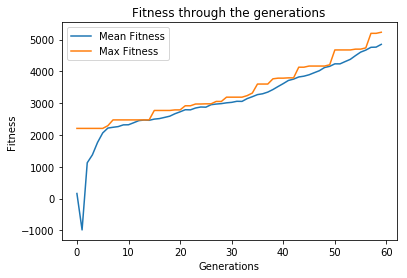

In [44]:
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()
#print(np.asarray(fitness_history).shape)

In [45]:
def GA_model_predict(test_data, weights):
    hx = sigmoid(test_data@(weights).T)
    pred = predict(hx)
    pred = pred.astype(int)
    return pred[0][0]

In [46]:
scores, choices = [], []
for each_game in range(10):
    score = 0
    game_memory, prev_obs = [], []
    env.reset()
    for _ in range(goal_steps):
        env.render()
        if len(prev_obs) == 0:
            action = random.randrange(0,2)
        else:
            action = GA_model_predict(prev_obs, weights)
        choices.append(action)    
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score += reward
        if done:
            break
    scores.append(score)        
print('Average Score:',print('Average Score:',np.mean(scores)))
#print('choice 1:{}  choice 0:{}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
print(score_requirement)
print(scores)
    

Average Score: 9.4
Average Score: None
50
[9.0, 9.0, 11.0, 9.0, 9.0, 10.0, 9.0, 10.0, 9.0, 9.0]


In [47]:
env.close()